In [2]:
import networkx as nx
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableSequence

import re 
import numpy as np
from networkx.algorithms.approximation import traveling_salesman_problem
from dotenv import load_dotenv

import googlemaps
import os
from geopy.geocoders import Nominatim
import time

from plotting import plot_graph_and_path, plot_route_folium

load_dotenv("hidden.env")

True

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
maps_API_KEY = os.getenv('maps_API_KEY')
gmaps = googlemaps.Client(key=maps_API_KEY) 
geolocator = Nominatim(user_agent="tsp")

def seconds_to_hours(seconds): 
    if type(seconds) == str:
        s = int(seconds.split())
    else: 
        s = seconds
    return s/3600

In [4]:
def get_location(location, number, node_type): 

    if not isinstance(location, str): 
        raise ValueError("Location must be a string")
    if not isinstance(number, int) or number < 1 or number > 10: 
        raise ValueError("Number must be a positive integer <= 10.")
    if not isinstance(node_type, str):
        raise ValueError("Node type must be a string, e.g. landmarks, towns, cities.")

    prompt = PromptTemplate(
        input_variables=["number", "location", "node_type"],
        template="List {number} {node_type} to visit in {location}. One per line, itemized."
    )

    chat = ChatOpenAI(model="gpt-4", temperature=1.0)
    chain = prompt | chat
    response = chain.invoke({"number": number,"location": location, "node_type": node_type})
    original_nodes = re.findall(r"\d+\.\s*(.+)", response.content)
    nodes = [node + ", " + location for node in original_nodes]
    
    return original_nodes, nodes


In [5]:
def fuel_price(location): 
    """ A function I intended to implement with an API or scraping to get the fuel price (in order to estimate cost). 
        For now, I will just use the LLM (which is very naive).
    """

    gbp = 1.03
    prompt = PromptTemplate(
        input_variables=["location"],
        template="Return 1.03 GBP in the local currency of {location}. Only the number."
    )
    chain = prompt | ChatOpenAI(model="gpt-4", temperature=0.0)
    response = chain.invoke({"location": location})
    try:
        price = float(response.content)
    except:
        price = gbp # in the event of failure just use gbp as a default 
    return price

In [6]:
def estimate_driving_cost(distance, fuel_price, fuel_efficiency = 6.5): 

    """ A function to estimate the cost of driving a given distance. The fuel efficiency is in litres per 100 km. 
        distance is in km. fuel_price is in local currency per litre. 
    """

    litres = distance * fuel_efficiency / 100 
    cost = litres * fuel_price
    return cost

In [7]:
def get_distances(nodes, number, priority): 
    
    if not isinstance(priority, list) or len(priority) != 3: 
        raise ValueError("Priority must be a list of three integers.")
    
    positions = {}
    backup_prompt = PromptTemplate(
        input_variables=["place"],
        template = "Return the longitude and latitude of {place}. "
                "In the format (latitude, longitude). No other text.")
    
    ## Now add in the LLM option (this is especially necessary for cases where the gmaps API fails)
    transport_prompt = PromptTemplate(
        input_variables=["place1", "place2"],
        template= "Return the time (in hours), the method of transport (e.g. plane, ferry, etc), "
        "the distance for that method (km), and the price (in the local currency) of using that method. "
        "This should be the best (combination of time, distance, and cost) way of travelling from {place1} to {place2}. "
        "Return it in this format: (method, time, distance, price). No other text.")

    mode_prompt = PromptTemplate(
        input_variables=["mode", "place1", "place2"],
        template= "Return the time (in hours), the distance (km), and the price (in the local currency) of travelling "
        "from {place1} to {place2} by {mode}. Return it in this format: (time, distance, price). No other text.")
    
    for i in range(number): 
        for _ in range(3): 
            # give three attempts to get the location, if not then use the LLM to get the location
            node = geolocator.geocode(nodes[i])
            if node: 
                break 
        if not node: 
            chat = ChatOpenAI(model="gpt-4", temperature=0.0)
            chain = backup_prompt | chat
            response = chain.invoke({"place": nodes[i]}).content
            match = re.search(r"\(?\s*(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)\s*\)?", response)
            if match:
                lat = float(match.group(1))
                lon = float(match.group(2))
            positions[i] = (lat, lon)
        else:
            positions[i] = (node.latitude, node.longitude)
            time.sleep(1) # to prevent overloading the geolocator API

    coords = list(positions.values())

    ## Get the distance matrices 
    walking_distances = gmaps.distance_matrix(coords, coords, mode = 'walking')
    driving_distances = gmaps.distance_matrix(coords, coords, mode = 'driving')
    bicycling_distances = gmaps.distance_matrix(coords, coords, mode = 'bicycling')
    transit_distances = gmaps.distance_matrix(coords, coords, mode = 'transit')

    superlatives = ["fastest", "shortest (distance)", "cheapest"]
    
    # At this point, we have the distance, time, but not cost for each pair of nodes 
    # I think we go off of the assumption that walking and cycling are free, and driving and transit have a cost 
    d = {} # d[i][j][mode] = [time, distance, cost]
    chat = ChatOpenAI(model="gpt-4", temperature=0.0)
    lists = [walking_distances, driving_distances, bicycling_distances, transit_distances]
        
    mode_names = ["foot", "car", "bike", "transit", "llm"]
    for origin in range(number): 

        d[origin] = {}
        
        for dest in range(number): 

            d[origin][dest] = {}

            if dest < origin: 
                d[origin][dest] = d[dest][origin]
                continue
            if dest == origin: 
                continue

            chain = transport_prompt | chat
            response = chain.invoke({"priority_superlative": superlatives[-1], "place1": nodes[origin], "place2": nodes[dest]}).content
            match = re.search(
                r"\(\s*(.+?)\s*,"             # Method
                r"\s*([\d.]+)\s*\w*\s*,"      # Time (float + optional 'hours' or 'h')
                r"\s*([\d.]+)\s*\w*\s*,"      # Distance (float + optional 'km' etc.)
                r"\s*(?:[\$£€]|)?([\d.]+)(?:\s*\w+)?\s*\)",  # Price: optional symbol or currency word
                response)

            if match:
                method = match.group(1)
                t = float(match.group(2))
                distance = float(match.group(3))
                cost = float(match.group(4))
                d[origin][dest]['llm'] = [t, distance, cost, method]
            
            else: 
                d[origin][dest]['llm'] = [np.inf, np.inf, np.inf, '']

            for i in range(4): 
                
                # Use the LLM if the API fails
                if lists[i]['status'] != 'OK':
                    chain = mode_prompt | chat
                    response = chain.invoke({"mode": mode_names[i], "place1": nodes[origin], "place2": nodes[dest]}).content
                    match = re.search(r"\(\s*([\d.]+\s*(?:h(?:ours?)?|hrs?))\s*,\s*([\d.]+\s*(?:km|kilometers?))\s*,\s*([^\)]+)\s*\)", response)
                    if match:
                        t = float(match.group(1).split()[0])
                        distance = float(match.group(2).split()[0])
                        cost = float(match.group(3))
                
                    # otherwise discount this method of transport 
                    else:
                        t, distance, cost = np.inf, np.inf, np.inf
                    
                    d[origin][dest][mode_names[i]] = [t, distance, cost]

                else:
                    element = lists[i]['rows'][origin]['elements'][dest]
                    dist = element['distance']['value']/1000
                    t = seconds_to_hours(element['duration']['value'])
                    if i in [0, 2]:
                        cost = 0
                    elif i == 1: 
                        cost = estimate_driving_cost(dist, fuel_price(nodes[origin]))
                    else: 
                        fare = element.get('fare', None)
                        if fare: 
                            cost = fare['value']
                        else:
                            cost = dist * 0.5 # just a placeholder for now 
                    
                    d[origin][dest][mode_names[i]] = [t, dist, cost]

    return d, positions

In [8]:
def get_best_method(d, priority, number):

    mode_names = ["foot", "car", "bike", "transit", "llm"]
    for origin in range(number): 
        for dest in range(origin + 1, number): 
            times, dists, costs = [], [], []
            for i in range(5): 
                times.append(d[origin][dest][mode_names[i]][0])
                dists.append(d[origin][dest][mode_names[i]][1])
                costs.append(d[origin][dest][mode_names[i]][2])

            times = np.array(times)
            dists = np.array(dists)
            costs = np.array(costs)

            max_t = np.max([j for j in times if j < np.inf])
            max_d = np.max([j for j in dists if j < np.inf])
            max_c = np.max([j for j in costs if j < np.inf])

            eps = 1e-6

            weighted_costs = (priority[0] + eps) * (times / (max_t + eps)) 
            weighted_costs += (priority[1] + eps) * (dists / (max_d + eps))
            weighted_costs += (priority[2] + eps) * (costs / (max_c + eps)) 
            best = mode_names[np.argmin(weighted_costs)]
            d[origin][dest]['best'] = best 
            d[origin][dest]['best_cost'] = np.min(weighted_costs)
    
    return 

In [9]:
def build_graph(d, number, nodes): 

    G = nx.complete_graph(number)
    labels = {i: nodes[i] for i in range(number)}

    for i in range(number): 
        for j in range(i + 1, number): 
            G[i][j]["weight"] = d[i][j]['best_cost']
    
    return G, labels

In [10]:
def solve_graph(G, d, original_nodes, cycle = False):

    tsp_path = traveling_salesman_problem(G, weight='weight', cycle=cycle)

    # Modes 
    total_t, total_d, total_c = 0, 0, 0
    for journey in range(len(tsp_path) - 1): 
        method = d[tsp_path[journey]][tsp_path[journey + 1]]['best']
        t, dist, c = d[tsp_path[journey]][tsp_path[journey + 1]][method][:3]

        total_t += t
        total_d += dist
        total_c += c

        if method == 'llm': 
            m = d[tsp_path[journey]][tsp_path[journey + 1]]['llm'][3]
            print(f"{original_nodes[tsp_path[journey]]} -> {original_nodes[tsp_path[journey + 1]]}: {m}, time: {t:.2f}, distance: {dist:.2f}, cost: {c:.2f}")
        else: 
            print(f"{original_nodes[tsp_path[journey]]} -> {original_nodes[tsp_path[journey + 1]]}: {method}, time: {t:.2f}, distance: {dist:.2f}, cost: {c:.2f}")
    
    print(f"Total time: {total_t:.2f} hours.")
    print(f"Total distance: {total_d:.2f} km.")
    print(f"Total cost: {total_c:.2f} local currency.")
    totals = [total_t, total_d, total_c]
    return tsp_path, totals

In [11]:
location = "London"
number = 6
node_type = "landmarks"
p = [1, 1, 1]

original_nodes, nodes = get_location(location, number, node_type)
d, positions = get_distances(nodes, len(nodes), p)

The London Eye -> The Shard: bike, time: 0.23, distance: 3.42, cost: 0.00
The Shard -> The British Museum: bike, time: 0.33, distance: 4.64, cost: 0.00
The British Museum -> Buckingham Palace: car, time: 0.25, distance: 3.03, cost: 0.20
Buckingham Palace -> Big Ben and the Houses of Parliament: bike, time: 0.10, distance: 1.23, cost: 0.00
Big Ben and the Houses of Parliament -> The Tower of London: walking, time: 0.50, distance: 2.30, cost: 0.00
Total time: 1.41 hours.
Total distance: 14.62 km.
Total cost: 0.20 local currency.


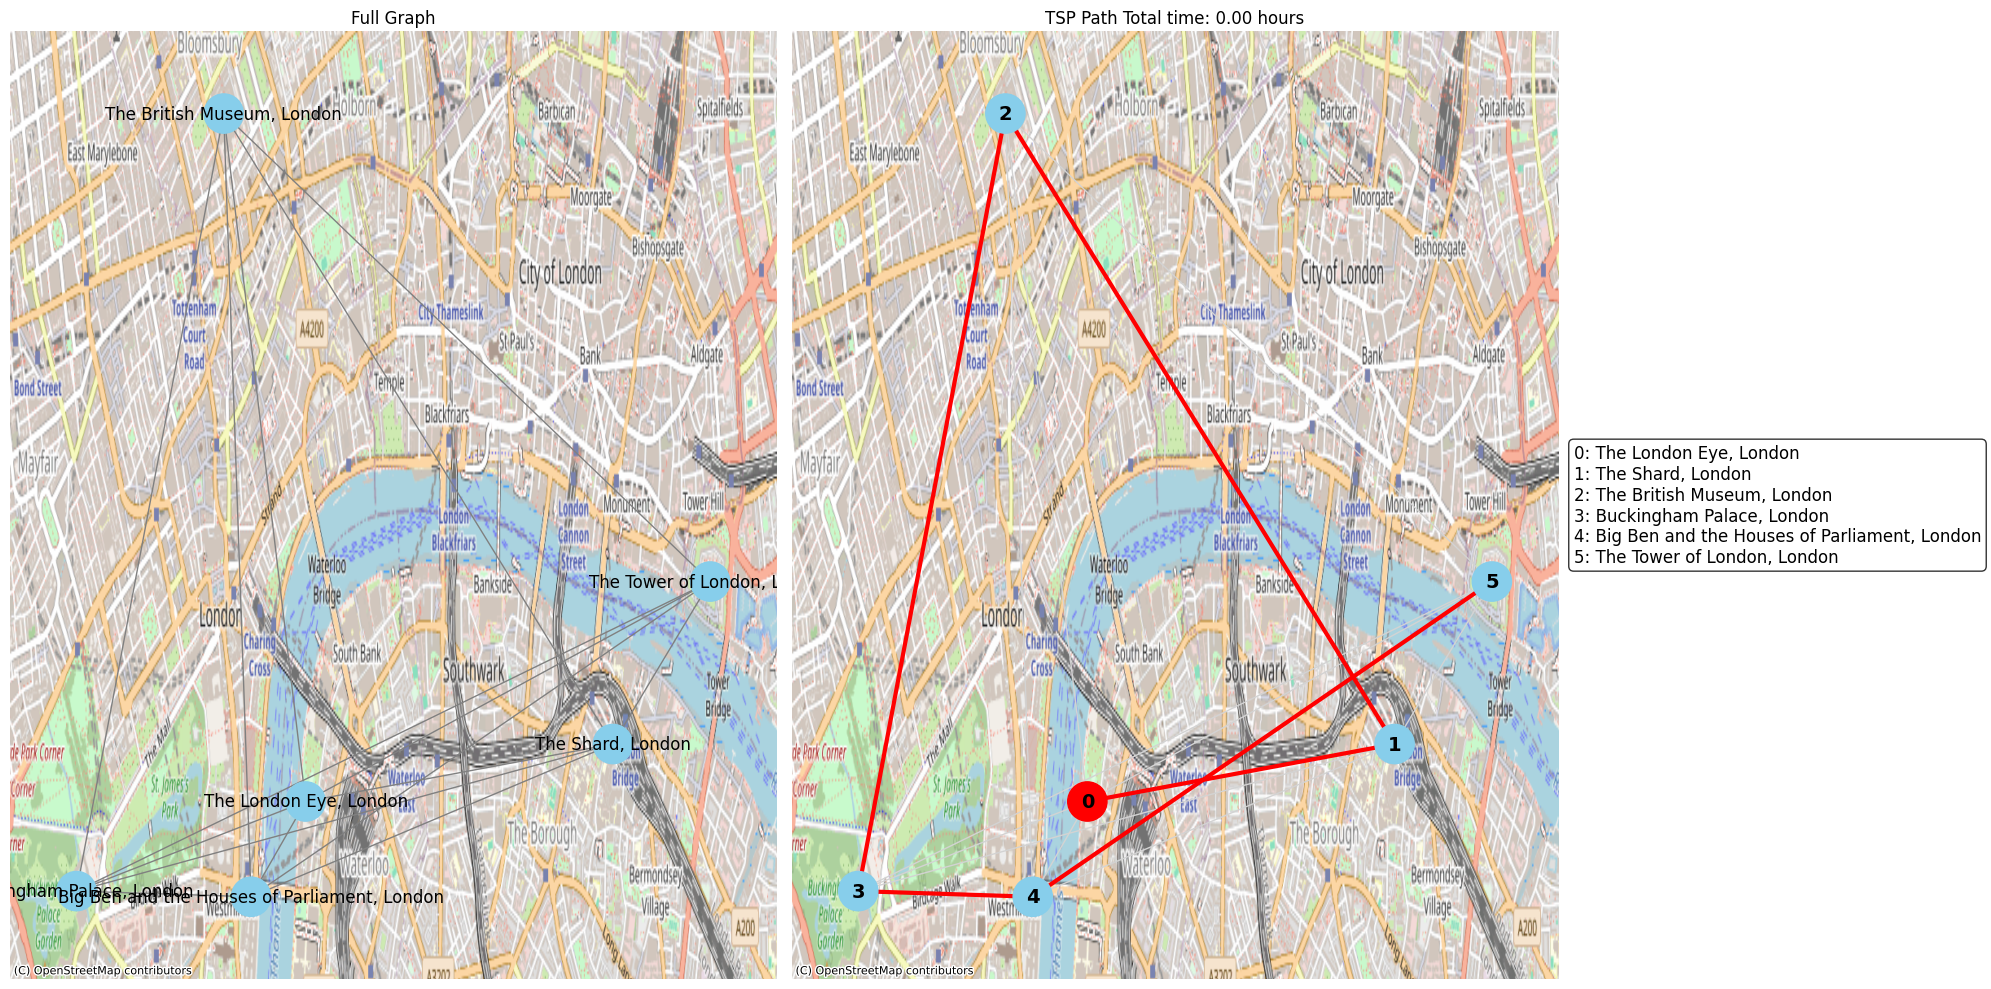

In [12]:
p = [1, 1, 1] # time, distance, cost
get_best_method(d, p, len(nodes))
G, labels = build_graph(d, len(nodes), nodes)
tsp_path, total_cost = solve_graph(G, d, original_nodes, cycle = False)
plot_graph_and_path(G, tsp_path, positions, nodes, 0, 0, map=True)

In [14]:
plot_route_folium(tsp_path, positions, nodes, total_cost)